In [97]:
from collections import defaultdict
import numpy as np
from numpy.random import choice
import pandas as pd
from random import random, sample
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sb

from bandit_classes2 import *

# Volatile Bandits Demo

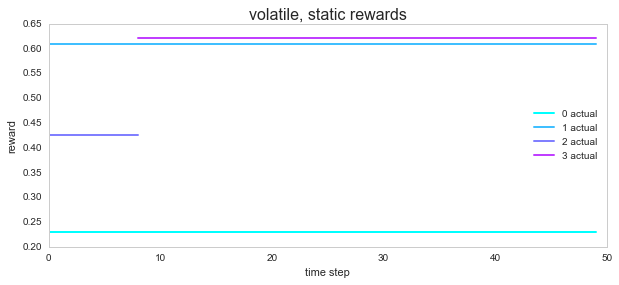

In [99]:
# data like {0:[(t1,v1),(t2,v2),...], 1:[(t1,v1),(t2,v2), ...], ...}
# defaultdict(list(tuples))
def plot_volatile_static_data(data, active, ax=None, 
                            title='volatile, static rewards',
                             colormap=plt.cm.cool):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,4))
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('time step')
    ax.set_ylabel('reward')
    ax.grid('off')
    ax.set_axis_bgcolor('white')
    
    k = len(data.keys())
    i = 0
    for arm_id, time_val_dict in data.items():
        if colormap:
            color = colormap(float(i)/k)
        else:
            color = 'k'
        xytups = sorted(time_val_dict.items())
        #print(arm_id)
        #print([e[0] for e in xytups])
        xs, ys = zip(*xytups)
        ax.plot(xs, ys, linewidth=2, c=color,  label=str(i)+' actual')
        i += 1
    ax.legend(loc='best')
    #sb.set_style("white")
    
def gen_volatile_static_data(k = 10, T = 300, p = 0.01):
    data = defaultdict()
    active = defaultdict(set)
    n = 0
    for arm_id in range(k):
        data[arm_id] = defaultdict(float)
        data[arm_id][0] = np.random.rand()
        active[0].add(arm_id)
        n += 1
    for t in range(1,T):
        next_active = set([])
        for i in active[t-1]:
            data[i][t] = data[i][t-1]
            if random() > p: # stay alive
                next_active.add(i)
            else:
                data[n] = defaultdict(float)
                data[n][t] = np.random.rand()
                next_active.add(n)
                n += 1
        active[t] = next_active
    return data, active

def gen_volatile_beta_data(k = 10, T = 300, p = 0.01, a = 1, b = 10):
    data = defaultdict()
    active = defaultdict(set)
    n = 0
    for arm_id in range(k):
        data[arm_id] = defaultdict(float)
        data[arm_id][0] = np.random.beta(a, b)# stats.beta.rvs(a,b,1)
        active[0].add(arm_id)
        n += 1
    for t in range(1,T):
        next_active = set([])
        for i in active[t-1]:
            data[i][t] = data[i][t-1]
            if random() > p: # stay alive
                next_active.add(i)
            else:
                data[n] = defaultdict(float)
                data[n][t] = np.random.beta(a, b) #stats.beta.rvs(a,b,1)
                next_active.add(n)
                n += 1
        active[t] = next_active
    return data, active

k, T = 3, 50
#data, active = gen_volatile_static_data(k, T)
data, active = gen_volatile_beta_data(k, T, a=5,b=5)
#print(data)#, active)
#print(active)
plot_volatile_static_data(data, active)

## plotting bandit beliefs

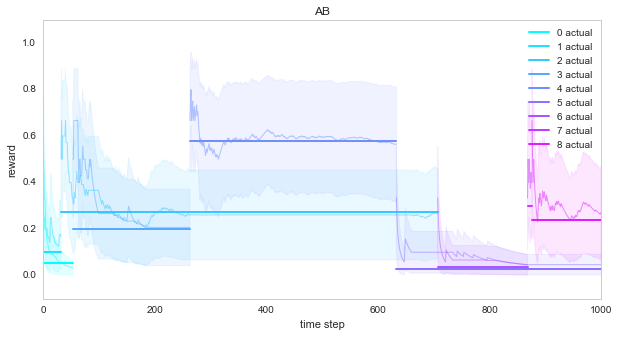

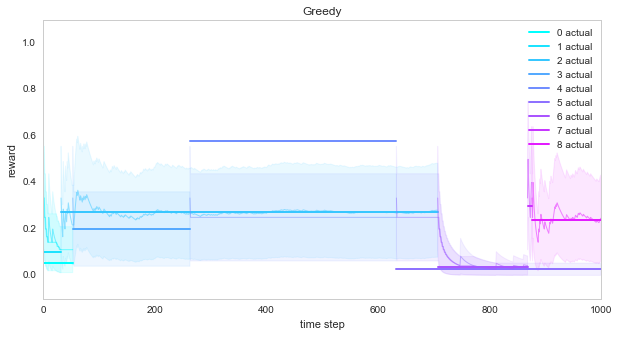

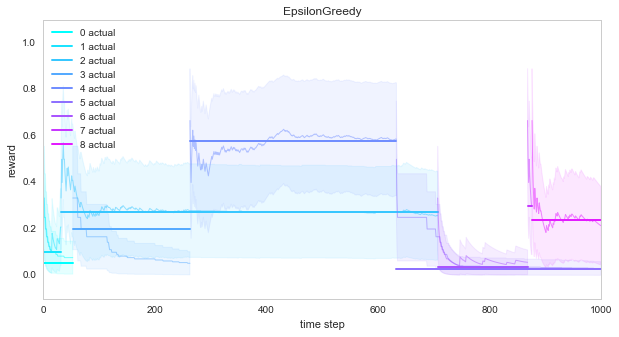

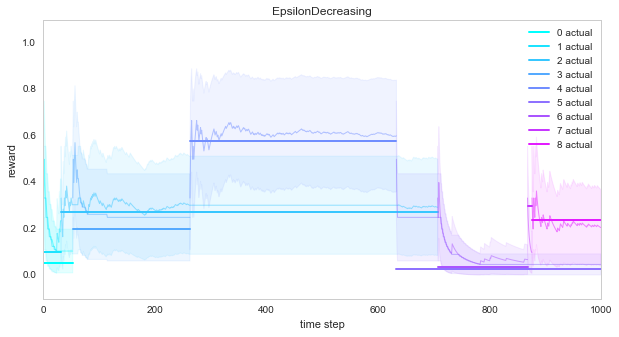

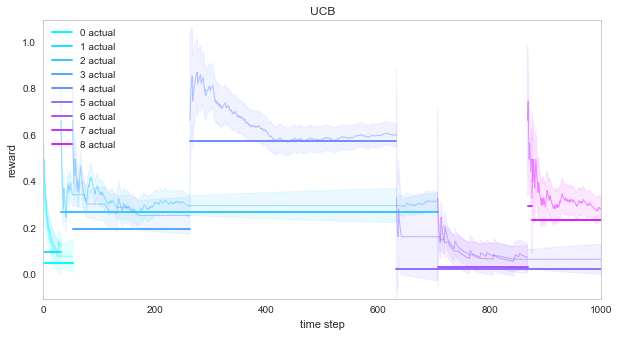

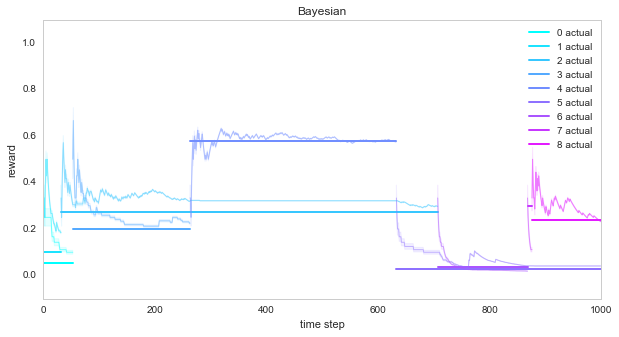

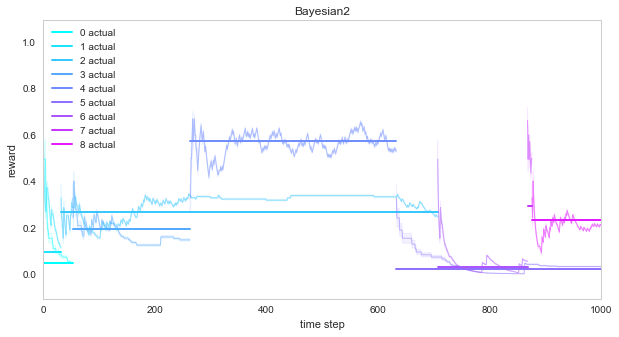

In [103]:
def test_volatile(k = 2, T = 10, 
                data = None,
                active = None,
                bandit = None):
    rewards = np.zeros(T)
    expected_values = defaultdict(list) # key: arm_id, value: [(t1, mean), (t2, mean), ...]
    variances = defaultdict(list)# key: arm_id, value: [(t1, var), (t2, var), ...]
    regret = np.zeros(T)
    for t in range(T):
        if t > 0:
            new_arms = [i for i in active[t] if i not in active[t-1]]
            #if len(new_arms) > 0:
                #print('new_arms',new_arms)
            for arm_id in sorted(new_arms):
                #print('adding', arm_id)
                bandit.add_arm(arm_id)
        #print('arms', bandit.arms.keys())
        arm = bandit.choose_arm()
        #print(t)
        #print(bandit.arms.keys())
        #print([data[i][t] for i in active[t]])
        best = max([data[i][t] for i in active[t]])
        reward = 0.0
        if data[arm][t] > np.random.random():
            reward = 1.0
        rewards[t] = reward
        regret[t] = (t+1)*best - rewards.sum() # cumulative regret
        bandit.update(arm, reward)
        for arm_id in bandit.arms.keys():
            expected_values[arm_id].append((t,bandit.get_expected_value(arm_id)))
            variances[arm_id].append((t,bandit.get_variance(arm_id)))
        if t > 0:
            dead_arms = [i for i in active[t-1] if i not in active[t]]
            #if len(dead_arms) > 0:
                #print('dead_arms', dead_arms)
            for arm_id in dead_arms:
                bandit.remove_arm(arm_id)

    regret = np.array(regret)
    return rewards, expected_values, variances, regret

def plot_arm_data_plus_actual(expected_values, variances, data, active,
                              #figsize=(15,8.45), 
                              figsize=(10,5),
                              colormap = plt.cm.cool,
                              fig_title='title'):
    fig, ax = plt.subplots(figsize=figsize)
    #max_timestep = int(max([lst[-1][0] for (k,lst) in expected_values.items()])) + 1
    plot_volatile_static_data(data, active, ax=ax)
    
    ax.set_title(fig_title); ax.grid('off')
    ax.set_xlabel('time step'); ax.set_ylabel('reward')
    ax.set_axis_bgcolor('white')
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('time step'); ax.set_ylabel('reward')
    k = len(expected_values.keys())
    for i, arm_id in enumerate(expected_values.keys()):
        color = colormap(i/float(k))
        xs, means = zip(*expected_values[arm_id])
        means = np.array(means)
        h = ax.plot(xs, means, color=color, alpha=0.5, label=str(i)+' arm', linewidth=1)
        xs, ys = zip(*variances[arm_id])
        ys = np.array(ys)
        ax.fill_between(xs, means+ys, means-ys, color=color, alpha=0.1, linewidth=1)    
    #ax.legend(loc='best')
    
def demo_bandits():
    k, T = 2, 1000
    #actual, news = gen_volatile_static_data(k, T, 0.005)
    #data, active = gen_volatile_static_data(k, T, 0.005)
    data, active = gen_volatile_beta_data(k,T,0.005,1,5)
    bandits = [
        AB(k), 
        Greedy(k),
        EpsilonGreedy(k, 0.1),
        EpsilonDecreasing(k),
        UCB(n_arms=k),
        Bayesian(k),
        Bayesian2(k, C=25)
        ]
    for b in bandits:
        bandit_name = b.__class__.__name__
        #print(bandit_name)
        rewards, expected_values, variances, regret = test_volatile(k, T, data, active, b)
        #print(arm_data)
        #print(expected_values)
        plot_arm_data_plus_actual(expected_values, variances, data, active, 
                                  fig_title=bandit_name)
        
demo_bandits()

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


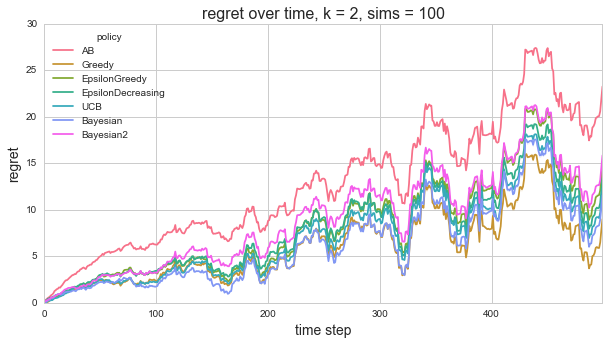

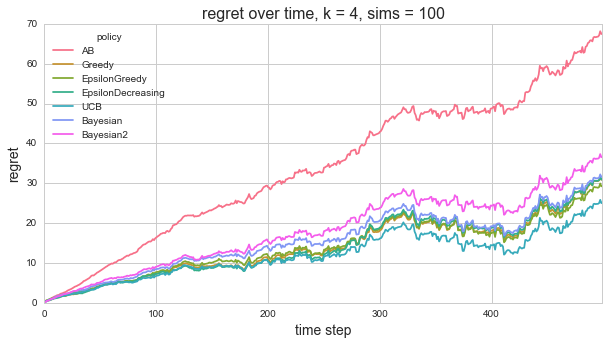

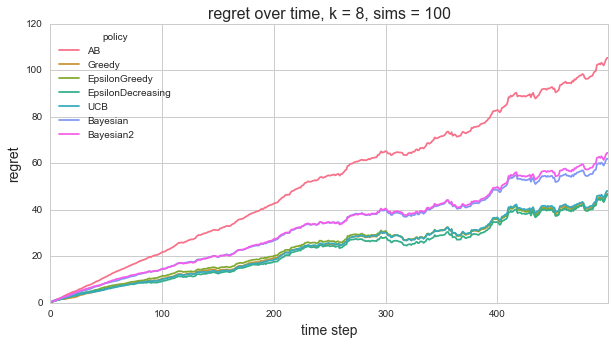

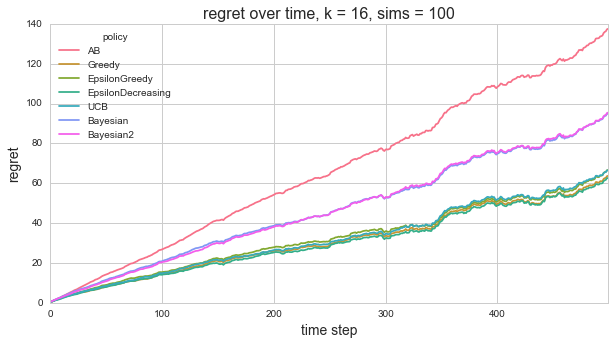

In [101]:
def do_sims(bandits, n_sims=10, k=20, T=100, data_gen=gen_volatile_static_data, 
            params=None):
    if data_gen == gen_volatile_beta_data:
        a, b = params['a'], params['b']
    ts = pd.Series(range(T))
    df_final = None
    for sim in range(n_sims):
        if data_gen == gen_volatile_beta_data:
            data, active = data_gen(k, T, a=a, b=b, p=params['p'])
        else:
            data, active = gen_volatile_static_data(k, T)
        #print(data)
        for i, bandit in enumerate(bandits):
            bandit = bandit(k)
            rewards, expected_values, variances, regret = test_volatile(k, T, data, active, bandit)
            rewards = rewards.tolist()
            df = pd.DataFrame(ts, columns=['time'])
            df['policy'] = [bandit.__class__.__name__]*T
            df['regret'] = regret
            df['sim'] = pd.Series([sim]*T)
            if df_final is None:
                df_final = df
            else:
                df_final = pd.concat([df_final, df], ignore_index=True)
    fig, ax = plt.subplots(figsize=(10,5), dpi=200)
    ax.set_title('regret over time, k = '+str(k)+', sims = '+str(n_sims), 
                 fontsize=16)
    sb.set_palette('colorblind')
    sb.set_style("whitegrid")
    sb.tsplot(df_final, time='time', unit='sim', value='regret', 
              condition='policy', ci=0, ax=ax)
    ax.set_xlabel('time step', fontsize=14)
    ax.set_ylabel('regret', fontsize=14)
    
bandits = [AB, Greedy, EpsilonGreedy, EpsilonDecreasing, UCB, Bayesian, Bayesian2]#, Bayesian3]
params = {'a': 5, 'b': 5, 'p': 0.01}
n_sims = 100
T = 500
for k in [2, 4, 8, 16]:
    #do_sims(bandits, n_sims, k, T, gen_volatile_static_data, params)
    do_sims(bandits, n_sims, k, T, gen_volatile_beta_data, params)



In [ ]:
data = [
    [1,1,0,0,0,0,0],
    [0,1,1,0,0,0,0],
    [1,1,1,0,0,0,0],
    [0,1,1,0,0,0,0],
    [0,1,1,0,0,0,0],
    [0,1,1,1,0,0,0],
    [0,1,0,0,1,0,0],
    [0,1,0,0,0,1,0],
    [0,1,1,1,0,0,1],
    [0,1,1,0,0,1,0],
]
#data = 
df = pd.DataFrame(data).T
print(df)
df.sum().plot()

In [ ]:
from sklearn import datasets

In [ ]:
iris = datasets.load_iris()
digits = datasets.load_digits()
iris.target.shape

In [ ]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(digits.data[:-1], digits.target[:-1])

In [ ]:
digits.data[:-1].shape, digits.target[:-1].shape

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
clf = KNeighborsClassifier(3)
clf.fit(iris.data, iris.target)

In [ ]:
accuracy_score(clf.predict(iris.data), iris.target)

In [ ]:
Y = list(iris.target)
#print(list(Y))
X = iris.data
res_final = []
bandit = Bayesian2(0, C=10)
bandit_k = Bayesian2(0, C=10)
for n in range(10,30):
    js = set(range(X.shape[0]))
    clfs = []
    xs, ys = [], []
    res = []
    for i in range(iris.data.shape[0]):
        j = sample(js, 1)[0]
        js.remove(j)
        #print j
        if i < n:
            guess = sample(Y, 1)[0]
            res.append(guess==Y[j])
        else:
            preds = []
            n_cls = bandit.choose_arms()
            for cl in clfs:
                preds.append(cl.predict(X[j]))
            pred = sample(preds, 1)[0]
            res.append(pred==Y[j])
        xs.append(X[j])
        ys.append(Y[j])
        if len(xs) == n:
            clf = KNeighborsClassifier(3)
            clf.fit(xs, ys)
            clfs.append(clf)
            arm_id = bandit.add_arm()
            bandit_k.add_arm()
            xs, ys = [], []
    d = pd.Series(res).astype(float)
    print(n, d.mean())
    res_final.append((n, d.mean()))
df = pd.DataFrame(res_final, columns=['n', 'res'])#.astype(int)
df.plot(x='n')